<a href="https://colab.research.google.com/github/andrewbowen19/CUNY-SQLBridge/blob/main/bowen_final_data604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA604 Final Project
Andrew Bowen
CUNY School of Professional Studies - Data Science


## Introduction
I am looking to simulate trip times for the Metropolitan Transit Authority's (MTA) subway system in New York City.

In [21]:
!pip install --q simpy

In [22]:
import requests as re
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# Import module and set up simpy environment variable
import simpy

env = simpy.Environment()

# Historical Data

I found [this dataset](https://data.ny.gov/Transportation/MTA-Access-A-Ride-Ride-Time-Beginning-2016/wtm4-vjm7) from NYC Open Data containing ride times for different routes between locations within New York City

In [24]:
# Look up historical dataset
response = re.get("https://data.ny.gov/resource/wtm4-vjm7.json")
df = pd.json_normalize(response.json())
df.head()

,service_date,month,year,provider_type,weekday_weekend,peak_offpeak,distance_category,origin_borough,destination_borough,totalridetimetrips,actualridetimetrips,tripsupto100percentageoftime,trips100to125percentageoftime,trips125to150percentageoftime,trips150to200percentageoftime,tripsover200percentageoftime
0,2021-10-07T00:00:00.000,10,2021,Primary,Weekday,OffPeak,0-3 miles,Bronx,Other,82,1487,61,7,7,4,3
1,2021-10-07T00:00:00.000,10,2021,Primary,Weekday,OffPeak,0-3 miles,Bronx,Bronx,2856,55057,2113,257,228,143,114
2,2021-10-07T00:00:00.000,10,2021,Primary,Weekday,OffPeak,0-3 miles,Bronx,Manhattan,190,4451,141,17,15,10,8
3,2021-10-07T00:00:00.000,10,2021,Primary,Weekend,OffPeak,0-3 miles,Bronx,Other,46,793,34,4,4,2,2
4,2021-10-07T00:00:00.000,10,2021,Primary,Weekend,OffPeak,0-3 miles,Bronx,Manhattan,82,1694,61,7,7,4,3


## Historical Average Trip Times
One measure that would be valuable for us to know when we are simulating trip times of different subway routes would be the average trip time of similar routes.

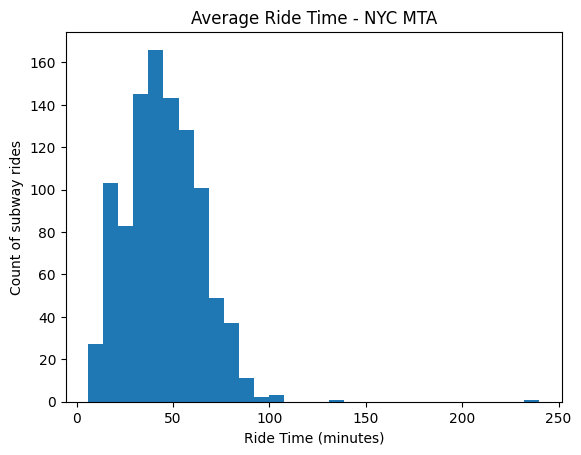

In [25]:
# Derivingg average ride time on a column level based on total rides and total ride time
df["actualridetimetrips"] = df["actualridetimetrips"].astype(int)
df['totalridetimetrips']  = df['totalridetimetrips'] .astype(int)
df["average_ride_time"] = df["actualridetimetrips"] / df['totalridetimetrips']

# Plot average ride times
plt.hist(df['average_ride_time'], bins=30)
plt.title("Average Ride Time - NYC MTA")
plt.xlabel("Ride Time (minutes)")
plt.ylabel("Count of subway rides")
plt.show()

Our distribution of ride times look to be roughly normal (slightly skewed right given we can't have a negative trip time). Let's print out our summary statistics below using `describe` from `pandas`

In [26]:
# Capture important summary stats and print
mean_ride_time = df.average_ride_time.mean()
std_ride_time = df.average_ride_time.std()
df.describe()

,totalridetimetrips,actualridetimetrips,average_ride_time
count,1000.000000,1000.000000,1000.000000
mean,346.181000,13477.484000,44.933467
std,804.210131,24038.004672,19.509683
min,1.000000,7.000000,6.000000
25%,21.000000,761.500000,31.077202
50%,102.000000,4666.000000,43.550897
75%,308.500000,14617.000000,57.662823
max,10820.000000,296044.000000,240.000000


In [27]:
# Interested in seeing the average time per distance category
time_by_dist = df.groupby('distance_category')["average_ride_time"].mean()

In [33]:
# getting distance counts per origin - destination boro
count_boro_combos = df.groupby(["origin_borough", "destination_borough"])["distance_category"].count()
count_boro_combos

origin_borough  destination_borough
Bronx           Bronx                  34
                Brooklyn               23
                Manhattan              42
                Other                  29
                Queens                 33
                Staten Island           3
Brooklyn        Bronx                  23
                Brooklyn               41
                Manhattan              42
                Other                  30
                Queens                 42
                Staten Island          16
Manhattan       Bronx                  41
                Brooklyn               41
                Manhattan              41
                Other                  25
                Queens                 41
                Staten Island           9
Other           Bronx                  29
                Brooklyn               37
                Manhattan              24
                Other                  42
                Queens                 3

Since our variable of interest is the trip time (our *dependent* variable of interest), it'll be helpful to define our *independent* variables of interest that may have an impact on our target variable


- Distance of trip

# Simulation

I'm using the [SimPy car wash tutorial as a good example](https://simpy.readthedocs.io/en/latest/examples/carwash.html) of a similar process I'm trying to model. In general, we need to simulate based on some input (*independent*) variables, with the ride time being the output (*dependent*) variable.

I pulled some constants from online search, such as using the [NYC MTA Wikipedia page](https://en.wikipedia.org/wiki/New_York_City_Subway) to find the number of trains used in NYC

In [ ]:
import random
from numpy.random import normal

In [79]:
# Defining simulation constants
RANDOM_SEED = 42
NUM_TRAINS = 6418 # number of train cars per NYC track
SIM_TIME = 60 * 24 # simulation time in minutes
BOROUGHS = ["Bronx", "Brooklyn", "Manhattan", "Other", "Staten Island", "Queens"]

# Setting seed for reproducability
random.seed(RANDOM_SEED)


class TrainTrack(object):

  def __init__(self, env, num_trains, distance, origin_boro, destination_boro):
    self.env = env
    self.track = simpy.Resource(env, num_trains)
    self.distance = distance
    self.origin_boro = origin_boro
    self.destination_boro = destination_boro
    self.travel_velocity = random.triangular(0, 55, 17.4) / 60 # convert to miles per min
    # time to travel at a given average speed - this will be shorter than the total travel time
    self.time_to_travel = self.distance * self.travel_velocity

  def trip(self, env):
    yield self.env.timeout(self.time_to_travel)
    print(f"Time to move from {self.origin_boro} to {self.destination_boro} \
            ({self.distance} mi): {self.time_to_travel} hr")


def train_ride(env, name, distance, origin_boro, destination_boro, num_stops, train):
  """
  The train process simulates the time taken due to stops, and delays from other trains
  """
  print(f"{origin_boro} => {destination_boro}")
  with train.track.request() as request:
    yield request
    for n in range(1, num_stops):
      # At each stop the train takes, some time passes. Most likely this is <1 minute but can be upt to 20 minutes within our simulation
      stop_time = random.triangular(0, 5, 0.5)
      print(f"Stop time at stop {n}: {stop_time} min")
      train.time_to_travel += stop_time
      yield env.timeout(stop_time)
  print(f'Travel time with stops: {train.time_to_travel}')


def setup(env, num_trains, distance, origin_boro, destination_boro, num_stops: int):
  """Setup function for Simpy environment"""
  # TODO: add train interdependence
  for i in range(NUM_TRAINS):

    # Get train name and origin/dest boroughs
    train_name = f"Train {i}"
    print(train_name)
    origin = random.choice(BOROUGHS)
    destination = random.choice(BOROUGHS)

    # Set up train track and simulate ride
    train = TrainTrack(env, num_trains, distance, origin, destination)
    yield env.timeout(normal(mean_ride_time, std_ride_time, 1))
    env.process(train_ride(env, train_name, distance, origin, destination, num_stops, train))


In [80]:
# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_TRAINS, 4, "Brooklyn", "Bronx", 10))

# Execute the simulation!
env.run(until=SIM_TIME)

Train 0
Train 1
Queens => Bronx
Stop time at stop 1: 2.5649645420836844 min
Stop time at stop 2: 2.302916105682937 min
Stop time at stop 3: 3.4424507305895657 min
Stop time at stop 4: 0.4662049780660224 min
Stop time at stop 5: 1.3935115337656474 min
Stop time at stop 6: 0.2729341469936949 min
Stop time at stop 7: 0.8070719578176728 min
Stop time at stop 8: 1.6639085717453206 min
Stop time at stop 9: 0.25756537851516276 min
Travel time with stops: 13.497686003385532
Train 2
Manhattan => Brooklyn
Stop time at stop 1: 1.8001848980874495 min
Stop time at stop 2: 0.8119114140118375 min
Stop time at stop 3: 1.9600128104230352 min
Stop time at stop 4: 2.9292960798924197 min
Stop time at stop 5: 0.12746332490231274 min
Stop time at stop 6: 2.9097687128545267 min
Stop time at stop 7: 2.3938795859045774 min
Stop time at stop 8: 1.1471616464812358 min
Stop time at stop 9: 0.6409047665559182 min
Travel time with stops: 15.694949532109089
Train 3
Brooklyn => Queens
Stop time at stop 1: 0.491722423

Help on Environment in module simpy.core object:

class Environment(builtins.object)
 |  Environment(initial_time: Union[int, float] = 0)
 |  
 |  Execution environment for an event-based simulation. The passing of time
 |  is simulated by stepping from event to event.
 |  
 |  You can provide an *initial_time* for the environment. By default, it
 |  starts at ``0``.
 |  
 |  This class also provides aliases for common event types, for example
 |  :attr:`process`, :attr:`timeout` and :attr:`event`.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, initial_time: Union[int, float] = 0)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  peek(self) -> Union[int, float]
 |      Get the time of the next scheduled event. Return
 |      :data:`~simpy.core.Infinity` if there is no further event.
 |  
 |  run(self, until: Union[int, float, simpy.events.Event, NoneType] = None) -> Optional[Any]
 |      Executes :meth:`step()` until the given criterion *until* is 

### TODO
- Add in multiple trains (e.g., `train 1, train 2`)
- Visualize output ride times to align to observed historical ride times
  - Calculate RMSE and run hypothesis test on simulated ride times
- Take ride times and

